In [138]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from datetime import datetime, timedelta
from collections import defaultdict

## Data Collection & Preprocessing

### Hypothesis

Air pollution levels in Hong Kong are influenced by both the total number of vehicles and the proportion of high-emission vehicles (above 2000cc) within the vehicle population. Larger vehicles, with higher engine capacities, are expected to contribute more significantly to air pollution, especially in dense urban areas.

### Datasets Selection

For this analysis, two key datasets were selected, which together provide a comprehensive view of air quality and vehicle trends in Hong Kong from 2017 to 2024:

	•	Hong Kong Air Quality Data (2017–2023): This dataset contains daily air pollutant measurements for various regions in Hong Kong. The pollutants tracked include nitrogen dioxide (NO₂), carbon monoxide (CO), fine suspended particulates (PM2.5), respirable suspended particulates (PM10), and sulfur dioxide (SO₂). These pollutants are directly linked to vehicular emissions and are therefore critical to the hypothesis.
	•	Hong Kong Vehicle Statistics (2020–2024): This dataset contains annual data on the number of vehicles registered in Hong Kong, categorized by engine capacity (cc rating). The dataset includes a breakdown of vehicles from 1000cc and below to those exceeding 3000cc. This data allows for an examination of trends in vehicle numbers and the impact of larger vehicles on air pollution.

These datasets were chosen for their relevance in understanding how vehicle emissions affect air quality. The overlap in the time period (2017–2023) allows for the two datasets to be compared and analyzed together.

### Data Cleaning and Preparation

Several data cleaning steps were undertaken to ensure the datasets were suitable for analysis:

	1.	Air Quality Data:
	•	The air quality dataset was first checked for missing values and duplicates using .isnull() and .duplicated() methods. Handling these issues ensured the dataset was complete and accurate.
	•	The column names were stripped of any leading or trailing spaces and converted to lowercase for consistency.
	•	The date column was converted to datetime format to allow for time-based analysis, and the value column (representing pollutant concentration levels) was converted to numeric, with invalid entries handled by setting them to NaN.
	•	Outliers in the pollutant values were identified using the Interquartile Range (IQR) method, which is a robust approach for detecting extreme values. This step ensured that abnormal values did not distort the results.
	2.	Vehicle Data:
	•	The vehicle dataset was also cleaned by checking for missing values and duplicates. Duplicate records were removed to avoid skewing the analysis.
	•	Outliers in the number column (representing the number of vehicles) were identified using the IQR method. This helped in detecting any unusual spikes in vehicle numbers, though none were found to be problematic.

### Feature Engineering

To better align the datasets with the hypothesis, several new features were created:

	•	Engine Capacity Classification: A binary column (above_2000cc) was created to mark whether a vehicle’s engine capacity exceeded 2000cc. This feature is important for understanding the impact of larger, high-emission vehicles on air pollution.
	•	Yearly Aggregation of Pollutants: The pollutant data was aggregated by year, region, and pollutant type to calculate annual average values. This aggregation allows for the analysis of long-term trends in air quality, aligning it with the annual vehicle data.
	•	Vehicle Aggregation by Year: The vehicle data was grouped by year and engine capacity, enabling the calculation of total vehicles and the number of large vehicles (above 2000cc) for each year. This step is crucial for comparing trends in vehicle populations with air quality levels.

### Merging the Datasets

After preprocessing, the air quality and vehicle datasets were merged on the year column. This allowed for direct comparisons between the total number of vehicles, the proportion of large vehicles, and the pollutant levels for each year. By merging the datasets, we can explore the relationships between vehicle trends and air pollution, setting the foundation for further analysis.

This preprocessing and feature engineering process ensures that the data is clean, aligned, and ready for further analysis, such as statistical modeling or visualization, to investigate the link between vehicular emissions and air quality.

In [57]:
# import hk air quality from 2017 to 2023.
hk_air = pd.read_csv('/Users/Java-file/5126-main/HongKong/hk-fix_air_daily.csv')
# import hk vehicle data from 2020 to 2024.
hk_vehicle = pd.read_csv('/Users/Java-file/5126-main/HongKong/hk-output_vehicle_statistics.csv')  

In [58]:
# Check whether there are null values in hk_air.
hk_air.isnull().sum()

DATE         0
POLLUTANT    0
region       0
value        0
dtype: int64

In [59]:
# Strip any leading/trailing spaces and convert all column names to lowercase
hk_air.columns = hk_air.columns.str.strip().str.lower()

# Check the updated column names to confirm
print(hk_air.columns)

Index(['date', 'pollutant', 'region', 'value'], dtype='object')


In [60]:
# Determine whether there are null values in hk_vehicle.
hk_vehicle.isnull().sum()

year         0
cc_rating    0
number       0
dtype: int64

In [61]:
# Check whether there are duplicated values in hk_air.
print(f"There are {hk_air.duplicated().sum()} duplicates in hk_air DataFrame")
# Check whether there are duplicated values in hk_vehicle.
print(f"There are {hk_vehicle.duplicated().sum()} duplicates in hk_vehicle DataFrame")
if hk_vehicle.duplicated().sum() > 0:
    duplicates_hk_vehicle = hk_vehicle[hk_vehicle.duplicated()]
    hk_vehicle = hk_vehicle.drop(duplicates_hk_vehicle.index)
# Check whether there are duplicated values in hk_vehicle.
print(f"There are {hk_vehicle.duplicated().sum()} duplicates in hk_vehicle DataFrame after processed")

# Convert  hk_air 'date' column type to datetime
hk_air['date'] = pd.to_datetime(hk_air['date'])
# Convert hk_air 'value' column to numeric, forcing errors to NaN
hk_air['value'] = pd.to_numeric(hk_air['value'], errors='coerce')
# Drop rows with NaN values in hk_air 'value' column if necessary
hk_air = hk_air.dropna(subset=['value'])
# Ensure 'value' is treated as a numeric column
print(hk_air.dtypes)

There are 0 duplicates in hk_air DataFrame
There are 5 duplicates in hk_vehicle DataFrame
There are 0 duplicates in hk_vehicle DataFrame after processed
date         datetime64[ns]
pollutant            object
region               object
value               float64
dtype: object


In [62]:
# Create a dictionary to store outliers for air quality
outliers_dict = {}

# Iterate over each unique pollutant
for pollutant in hk_air['pollutant'].unique():
    hk_pollutant = hk_air[hk_air['pollutant'] == pollutant]
    
    # Calculate IQR
    Q1 = hk_pollutant['value'].quantile(0.25)
    Q3 = hk_pollutant['value'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Get the outliers
    outliers = hk_pollutant[
        (hk_pollutant['value'] < lower_bound) | 
        (hk_pollutant['value'] > upper_bound)
    ]

    # Store the result
    if outliers.empty:
        print(f"No outliers found for {pollutant}")
    else:
        print(outliers.head())
        outliers_dict[pollutant] = outliers

           date        pollutant    region  value
889  2017-01-08  Carbon Monoxide   CENTRAL  139.0
924  2017-01-08  Carbon Monoxide  MONG KOK  126.0
1015 2017-01-09  Carbon Monoxide   CENTRAL  139.0
1050 2017-01-09  Carbon Monoxide  MONG KOK  138.0
1092 2017-01-09  Carbon Monoxide   TAP MUN  130.0
          date                     pollutant        region  value
253 2017-01-03  Fine Suspended Particulates   CAUSEWAY BAY   44.0
358 2017-01-03  Fine Suspended Particulates       TUEN MUN   49.0
365 2017-01-03  Fine Suspended Particulates     TUNG CHUNG   44.0
610 2017-01-05  Fine Suspended Particulates       TUEN MUN   45.0
631 2017-01-06  Fine Suspended Particulates   CAUSEWAY BAY   45.0
          date         pollutant        region  value
128 2017-01-02  Nitrogen Dioxide  CAUSEWAY BAY  119.0
170 2017-01-02  Nitrogen Dioxide      MONG KOK  107.0
296 2017-01-03  Nitrogen Dioxide      MONG KOK  106.0
513 2017-01-05  Nitrogen Dioxide       CENTRAL  107.0
548 2017-01-05  Nitrogen Dioxide  

In [63]:
# Calculate the first quartile (25th percentile) of the 'number_of_inmates' column
Q1 = hk_vehicle['number'].quantile(0.25)
# Calculate the third quartile (75th percentile) of the 'number_of_inmates' column
Q3 = hk_vehicle['number'].quantile(0.75)
# Calculate the Inter-quartile Range (IQR) which is the difference between Q3 and Q1
IQR = Q3 - Q1
# Calculate the lower bound for outliers, typically 1.5 times below the IQR from Q1
lower_bound = Q1 - 1.5 * IQR
# Calculate the upper bound for outliers, typically 1.5 times above the IQR from Q3
upper_bound = Q3 + 1.5 * IQR
# Identify outliers: rows where 'number_of_inmates' is either below the lower bound or above the upper bound
outliers = hk_vehicle[(hk_vehicle['number'] < lower_bound) | (hk_vehicle['number'] > upper_bound)]
outliers.head()

,year,cc_rating,number


In [109]:
# Extract the 'year' from the 'date' column and add it as a new column in the dataframe
hk_air['year'] = hk_air['date'].dt.year

# Define a list of pollutants that we are interested in analyzing
pollutants_of_interest = [
    'Carbon Monoxide', 
    'Fine Suspended Particulates', 
    'Nitrogen Dioxide', 
    'Nitrogen Oxides', 
    'Ozone', 
    'Respirable Suspended Particulates', 
    'Sulphur Dioxide '
    ]

# Filter the dataset to include only rows where the 'pollutant' is in the list of pollutants of interest
hk_filtered_pollutant = hk_air[hk_air['pollutant'].isin(pollutants_of_interest)]

# Group the filtered data by 'year', 'region', and 'pollutant' and calculate the mean for each group.
# This will give the average pollutant values by year, region, and pollutant.
hk_annual_avg_pollutant = hk_filtered_pollutant.groupby(['year', 'region', 'pollutant']).mean().reset_index()


# Filter the dataset to include only rows where the 'region' is 'national', as you are interested in national data.
hk_central_annual_avg_pollutant = hk_annual_avg_pollutant[hk_annual_avg_pollutant['region'] == 'CENTRAL']



# Drop the 'date' column since it is no longer relevant after grouping by year (and is presumably not needed for further analysis).
hk_central_annual_avg_pollutant.drop('date', axis=1, inplace=True)

/var/folders/m_/q9gtbt5110q8qm3xhl5j_j9m0000gn/T/ipykernel_75447/1837904618.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hk_central_annual_avg_pollutant.drop('date', axis=1, inplace=True)


In [110]:
print(hk_central_annual_avg_pollutant)

     year   region                          pollutant       value
5    2017  CENTRAL                    Carbon Monoxide   68.713889
6    2017  CENTRAL                   Nitrogen Dioxide   79.695055
7    2017  CENTRAL                    Nitrogen Oxides  175.711538
8    2017  CENTRAL                              Ozone   26.543956
9    2017  CENTRAL  Respirable Suspended Particulates   32.971989
77   2018  CENTRAL                    Carbon Monoxide   82.799451
78   2018  CENTRAL                   Nitrogen Dioxide   79.818681
79   2018  CENTRAL                    Nitrogen Oxides  185.747253
80   2018  CENTRAL                              Ozone   25.365385
81   2018  CENTRAL  Respirable Suspended Particulates   33.464589
149  2019  CENTRAL                    Carbon Monoxide   84.522099
150  2019  CENTRAL                   Nitrogen Dioxide   79.717033
151  2019  CENTRAL                    Nitrogen Oxides  171.771978
152  2019  CENTRAL                              Ozone   35.991758
153  2019 

In [127]:
# Create a new boolean column 'above_2000cc' to mark whether each row's 'cc_rating' falls into categories above 2000cc
hk_vehicle['above_2000cc'] = hk_vehicle['cc_rating'].apply(
    lambda x: '2001-3000cc' in x or '3001cc and above' in x or 'above' in x)

# Group the data by 'year' and use the agg function to aggregate total vehicle count 
hk_yearly_vehicles_and_large_vehicle = hk_vehicle.groupby('year').agg(
    # 'hk_total_vehicles': Sum the 'number' column to get the total number of vehicles for each year
    hk_total_vehicles=('number', 'sum'),
    
    # 'total_above_2000cc': Custom aggregation function to sum 'number' only for rows where 'above_2000cc' is True
    total_above_2000cc=('number', lambda x: x[hk_vehicle.loc[x.index, 'above_2000cc']].sum())
).reset_index()  # Reset index to convert the grouped result back into a regular DataFrame

# Calculate the ratio of large vehicles (above 2000cc) to total vehicles for each year
hk_yearly_vehicles_and_large_vehicle['large_vehicle_ratio'] = hk_yearly_vehicles_and_large_vehicle['total_above_2000cc'] / hk_yearly_vehicles_and_large_vehicle['hk_total_vehicles']

# Display the result
hk_yearly_vehicles_and_large_vehicle.head()

,year,hk_total_vehicles,total_above_2000cc,large_vehicle_ratio
0,2020,48780,12946,0.265396
1,2021,47802,13610,0.284716
2,2022,33960,10684,0.314605
3,2023,26690,10132,0.379618
4,2024,14383,5541,0.385246


In [128]:
hk_merged_data = pd.merge(hk_central_annual_avg_pollutant, hk_yearly_vehicles_and_large_vehicle, on='year')

In [130]:
print(hk_yearly_vehicles_and_large_vehicle)

   year  hk_total_vehicles  total_above_2000cc  large_vehicle_ratio
0  2020              48780               12946             0.265396
1  2021              47802               13610             0.284716
2  2022              33960               10684             0.314605
3  2023              26690               10132             0.379618
4  2024              14383                5541             0.385246


## Data Visualization & Analysis

### Visualization Approach

This section focuses on visualizing the relationship between air pollution and vehicle metrics, and assessing the strength of these relationships through various plots and regression analyses.

### Data Visualization

The first set of visualizations compares the large vehicle ratio with the number of cars across different engine capacities (cc ratings). This helps understand the growth in vehicle numbers over time and how the proportion of large vehicles has evolved:
1.Plotting Large Vehicle Ratio and Car Population by CC Rating:
	•A dual-axis plot is used, where the left axis represents the large vehicle ratio, and the right axis shows the number of vehicles for each engine capacity category (1000cc and below, 1001-1600cc, etc.).
	•This visualization helps highlight the trends in large vehicles and their contribution to overall vehicle emissions.
2.Annual Average Pollutant Values:
	•A line plot is created for each pollutant, showing its average concentration by year. This provides a clear view of air quality trends over time for pollutants such as nitrogen oxides, carbon monoxide, and particulate matter.
	•This allows for a comparison of year-on-year changes in air pollution, with a focus on the pollutants most closely linked to vehicle emissions.

### Correlation Analysis

To quantify the relationship between air pollution and vehicle metrics, correlation matrices and regression models are used:

1.Correlation Heatmaps:
	•For each pollutant, a heatmap is drawn showing the correlation between air pollution levels (value), total vehicles (hk_total_vehicles), and the large vehicle ratio (large_vehicle_ratio). This helps identify which vehicle metric has the strongest correlation with specific pollutants.
	•Heatmaps are useful for visualizing the strength and direction of relationships between these variables.
2.Regression Plots:
	•Regression plots are created to explore how well vehicle metrics can predict pollutant concentrations. Separate regression models are generated for the total number of vehicles and the large vehicle ratio against each pollutant.
	•These regression plots provide a visual representation of the linear relationship between vehicle numbers and air pollution levels, with a fitted line to indicate the trend.

### Statistical Modeling

Finally, linear regression models are built to predict air pollution values based on vehicle metrics:

1.Multiple Linear Regression:
	•For each pollutant, a multiple linear regression model is fitted with two independent variables: the total number of vehicles and the large vehicle ratio.
	•The model’s predicted values are compared against actual pollutant values to assess the accuracy of the model.
	•This analysis helps quantify the contribution of large vehicles to air pollution and tests the hypothesis that larger vehicles contribute disproportionately to air quality degradation.
2.Actual vs Predicted Values:
	•Scatter plots are generated to compare actual and predicted pollution values for each pollutant. A reference line indicates perfect predictions, allowing for an easy assessment of model performance.

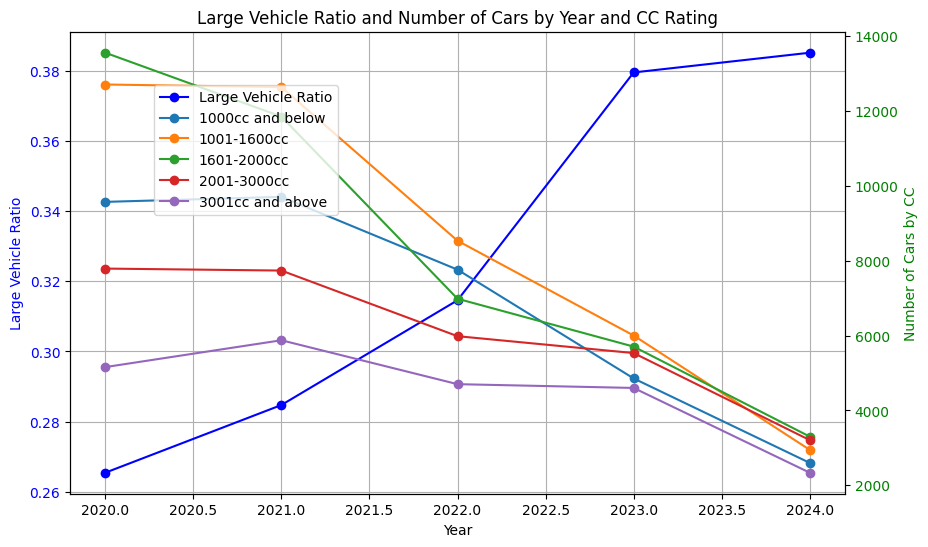

In [117]:
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot the large vehicle ratio on the left y-axis
ax1.plot(hk_yearly_vehicles_and_large_vehicle["year"], hk_yearly_vehicles_and_large_vehicle["large_vehicle_ratio"], marker='o', linestyle='-', color='b', label='Large Vehicle Ratio')
ax1.set_xlabel('Year')
ax1.set_ylabel('Large Vehicle Ratio', color='b')
ax1.tick_params(axis='y', labelcolor='b')

# Create a twin y-axis to plot number of cars by CC rating
ax2 = ax1.twinx()

# Filter the columns to exclude non-numeric and unwanted columns like 'year' and 'above_2000cc'
for cc_rating in ['1000cc and below', '1001-1600cc', '1601-2000cc', '2001-3000cc', '3001cc and above']:
    # Group the data by year and sum the number of vehicles for each cc_rating category
    cc_data = hk_vehicle[hk_vehicle['cc_rating'] == cc_rating].groupby('year').agg({'number': 'sum'}).reset_index()
    
    # Plot the data for each cc_rating
    ax2.plot(cc_data['year'], cc_data['number'], marker='o', label=cc_rating)

ax2.set_ylabel('Number of Cars by CC', color='g')
ax2.tick_params(axis='y', labelcolor='g')

# Adding a legend for the plots
fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9), bbox_transform=ax1.transAxes)

# Title and grid
plt.title('Large Vehicle Ratio and Number of Cars by Year and CC Rating')
ax1.grid(True)


plt.show()

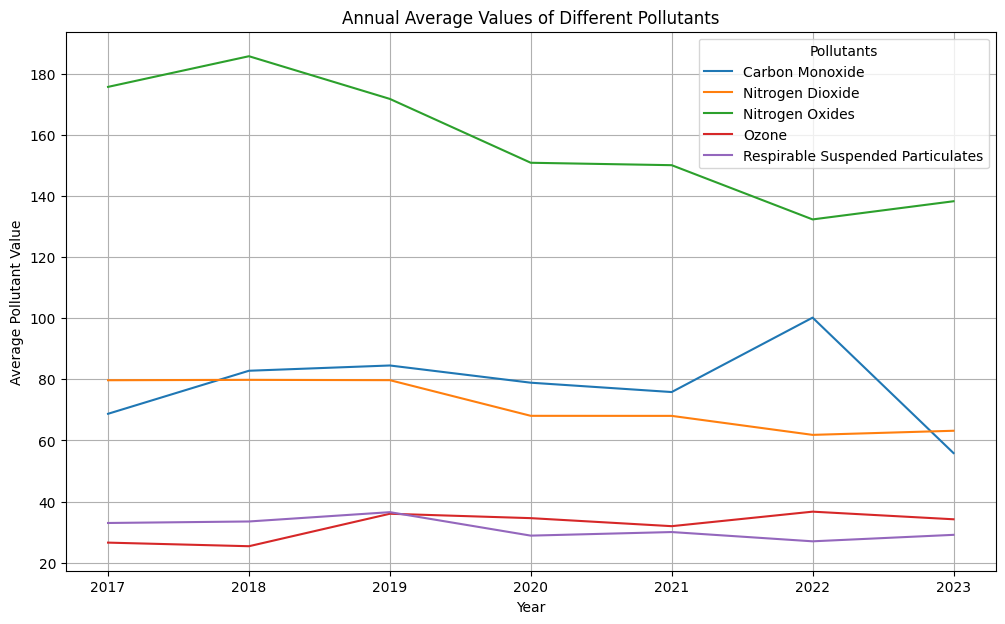

In [121]:
# Extract the pollutant to be analyzed
hk_pollutants = hk_central_annual_avg_pollutant['pollutant'].unique()

plt.figure(figsize=(12, 7))

for pollutant in hk_pollutants:
    # Filter out the current pollutant data
    hk_filtered_pollutant = hk_central_annual_avg_pollutant[hk_central_annual_avg_pollutant['pollutant'] == pollutant]    
    plt.plot( hk_filtered_pollutant['year'],  hk_filtered_pollutant['value'], label=pollutant)

plt.title('Annual Average Values of Different Pollutants')
plt.xlabel('Year')
plt.ylabel('Average Pollutant Value')
plt.legend(title='Pollutants')
plt.grid(True)
plt.show()

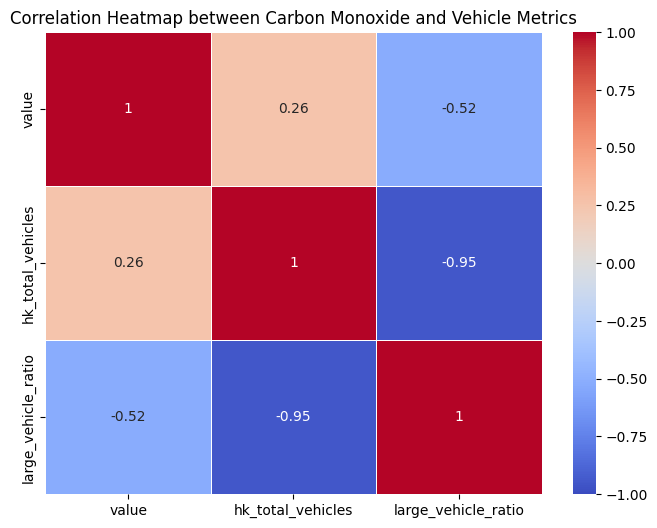

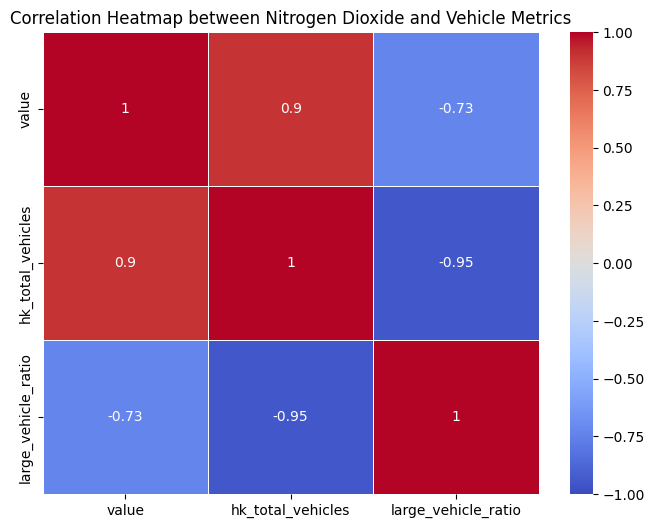

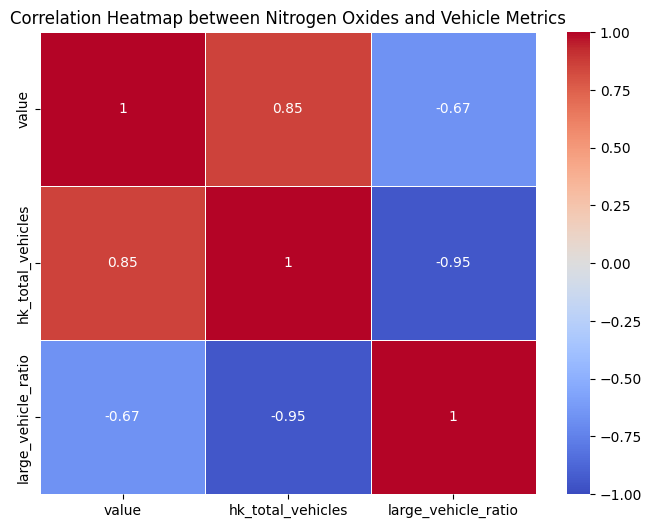

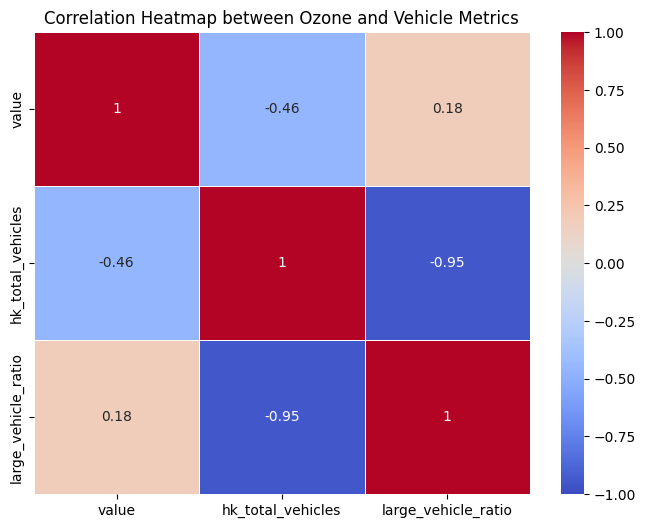

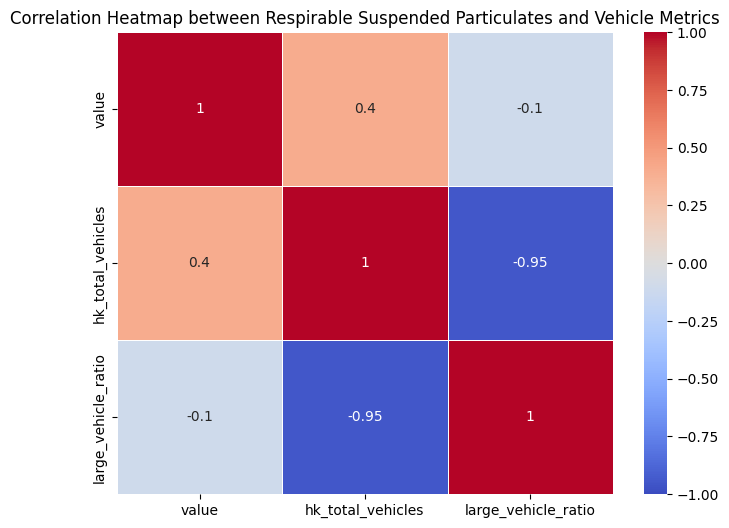

In [131]:
for pollutant in hk_pollutants:
    pollutant_data = hk_merged_data[hk_merged_data['pollutant'] == pollutant]

    correlation_matrix = pollutant_data[['value', 'hk_total_vehicles', 'large_vehicle_ratio']].corr()
    
    # Draw heat map to analysis the correlation among pollutant value, total vehicles and large vehicle ratio.
    plt.figure(figsize=(8, 6))
    sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", vmin=-1, vmax=1, linewidths=0.5)
    plt.title(f"Correlation Heatmap between {pollutant} and Vehicle Metrics")
    plt.show()

### Data Modelling and Analysis

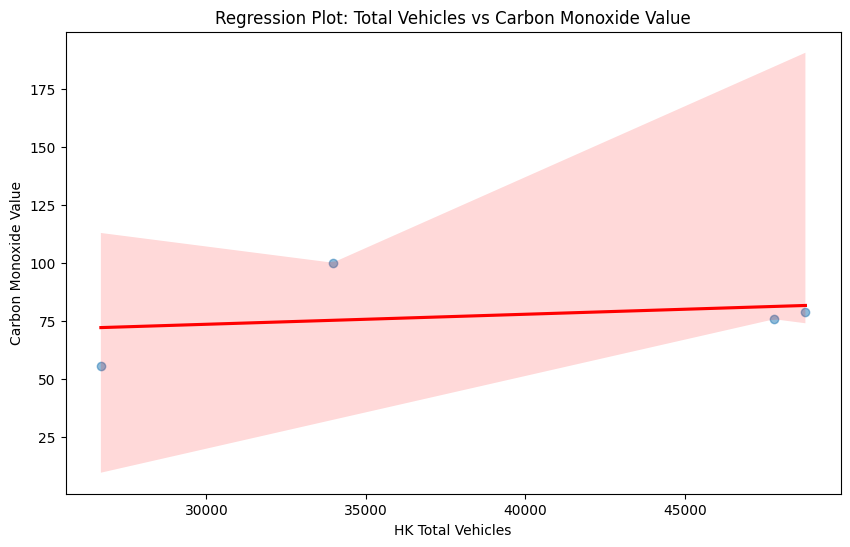

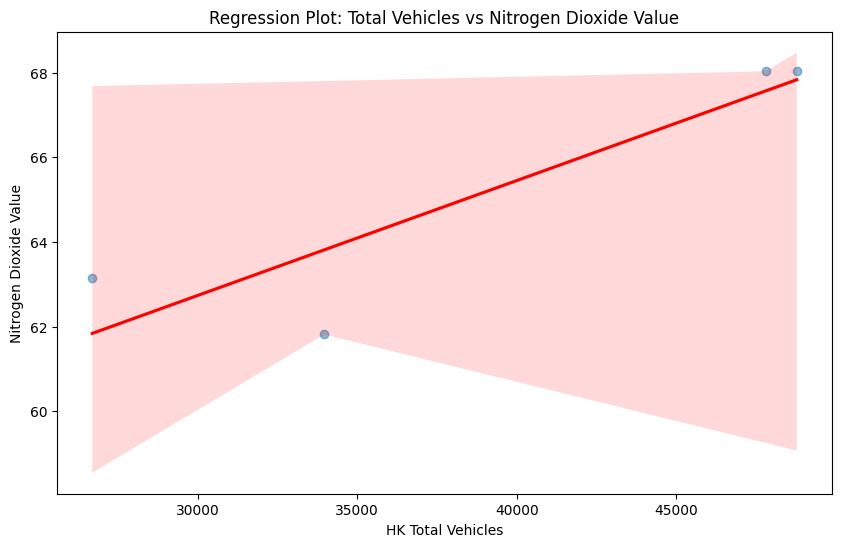

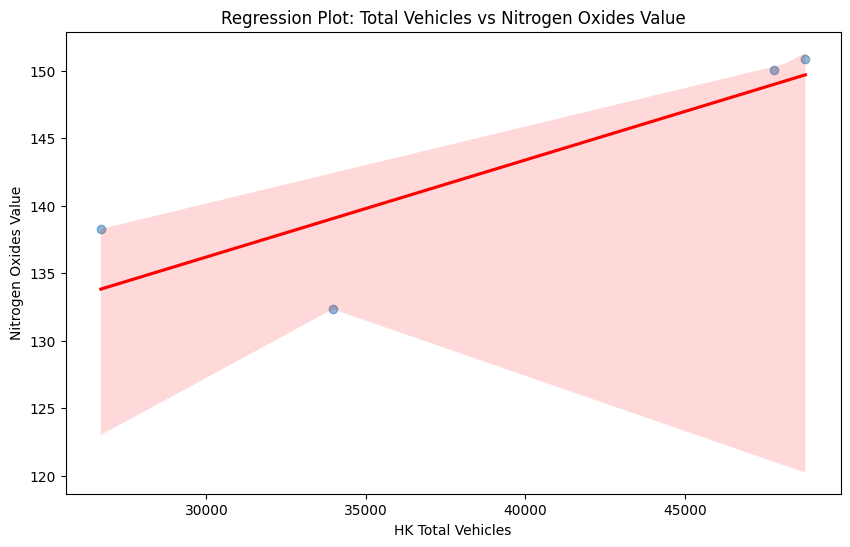

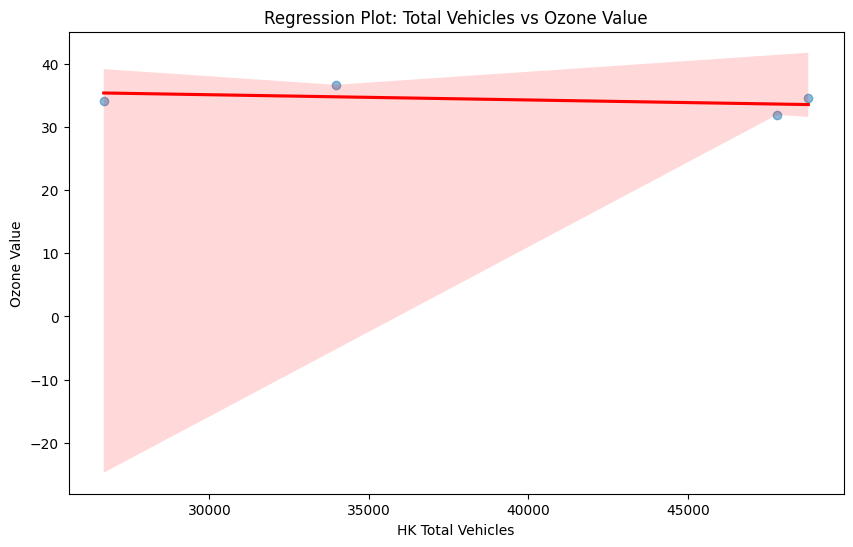

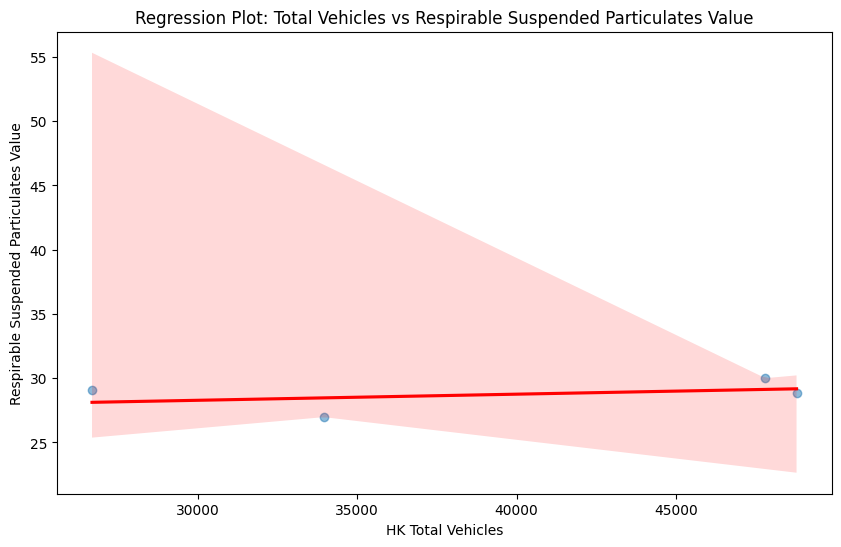

In [132]:
# 分别为每个污染物绘制 hk_total_vehicles 对 value 的回归拟合图
for pollutant in hk_pollutants:
    plt.figure(figsize=(10, 6))
    
    # 筛选出当前污染物的数据
    hk_pollutant_data = hk_merged_data[hk_merged_data['pollutant'] == pollutant]
    
    # 绘制 hk_total_vehicles 对 value 的回归拟合图
    sns.regplot(x='hk_total_vehicles', y='value', data=hk_pollutant_data, scatter_kws={'alpha':0.5}, line_kws={'color':'red'})
    plt.title(f'Regression Plot: Total Vehicles vs {pollutant} Value')
    plt.xlabel('HK Total Vehicles')
    plt.ylabel(f'{pollutant} Value')
    plt.show()
# 分别计算每个污染物的相关系数

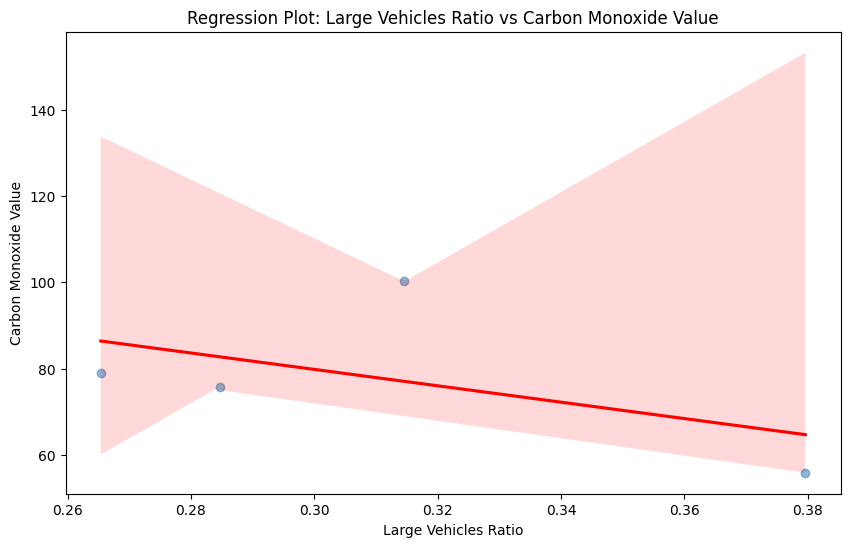

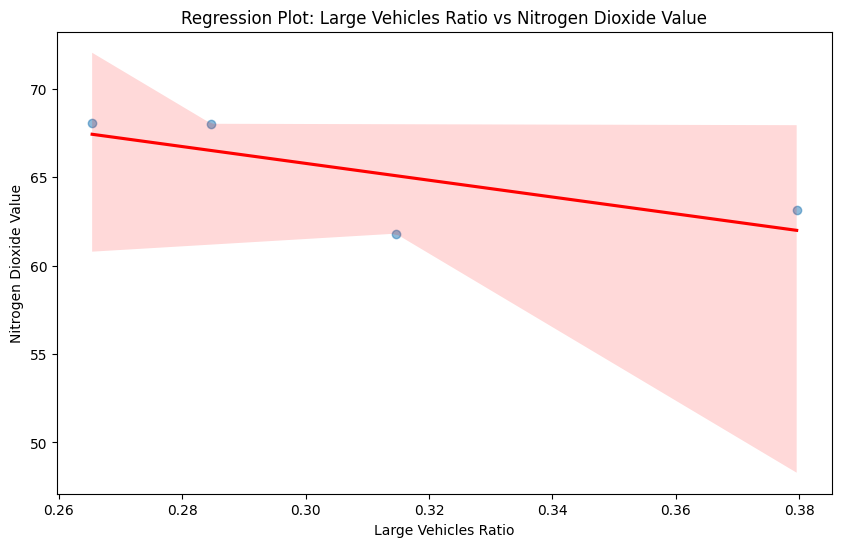

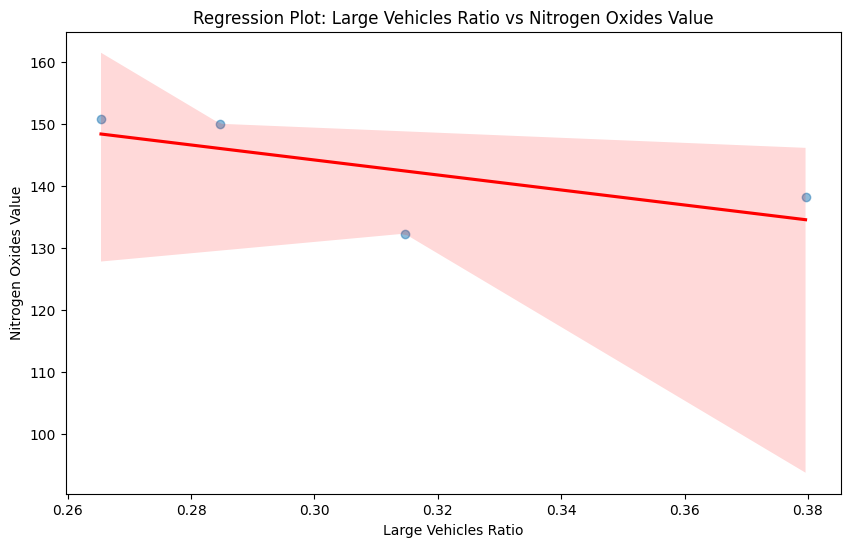

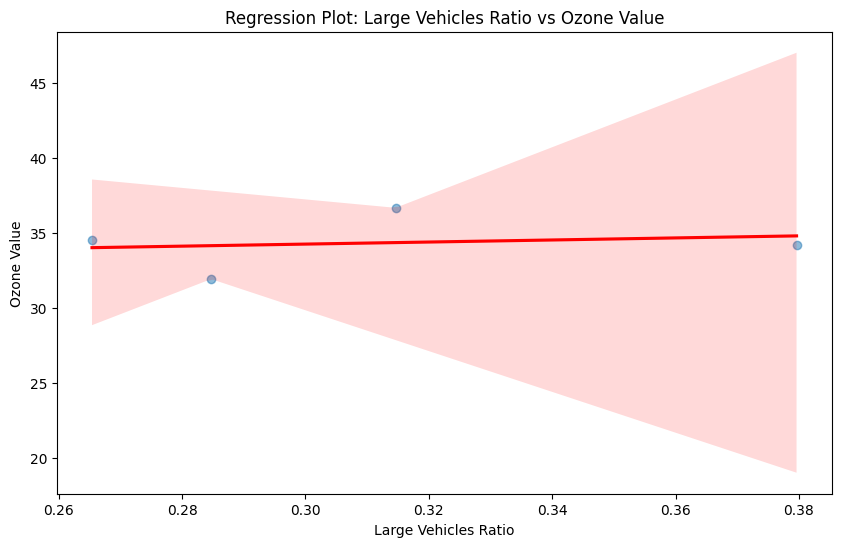

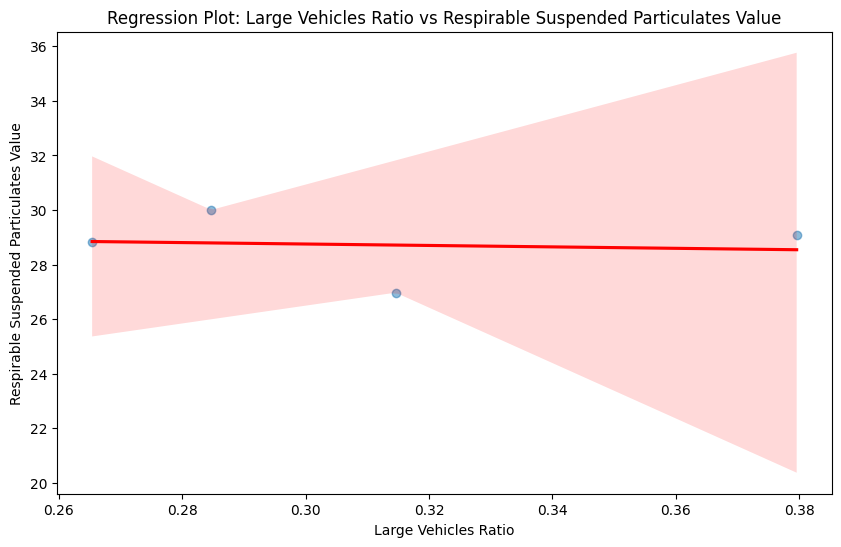

In [133]:
# 分别为每个污染物绘制 Large Vehicles Ratio 对 value 的回归拟合图
for pollutant in hk_pollutants:
    plt.figure(figsize=(10, 6))
    
    # 筛选出当前污染物的数据
    hk_pollutant_data = hk_merged_data[hk_merged_data['pollutant'] == pollutant]
    
    # 绘制 total_vehicles 对 value 的回归拟合图
    sns.regplot(x='large_vehicle_ratio', y='value', data=hk_pollutant_data, scatter_kws={'alpha':0.5}, line_kws={'color':'red'})
    plt.title(f'Regression Plot: Large Vehicles Ratio vs {pollutant} Value')
    plt.xlabel('Large Vehicles Ratio')
    plt.ylabel(f'{pollutant} Value')
    plt.show()

/var/folders/m_/q9gtbt5110q8qm3xhl5j_j9m0000gn/T/ipykernel_75447/1903181556.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hk_pollutant_data['predicted_value'] = model.predict(X)


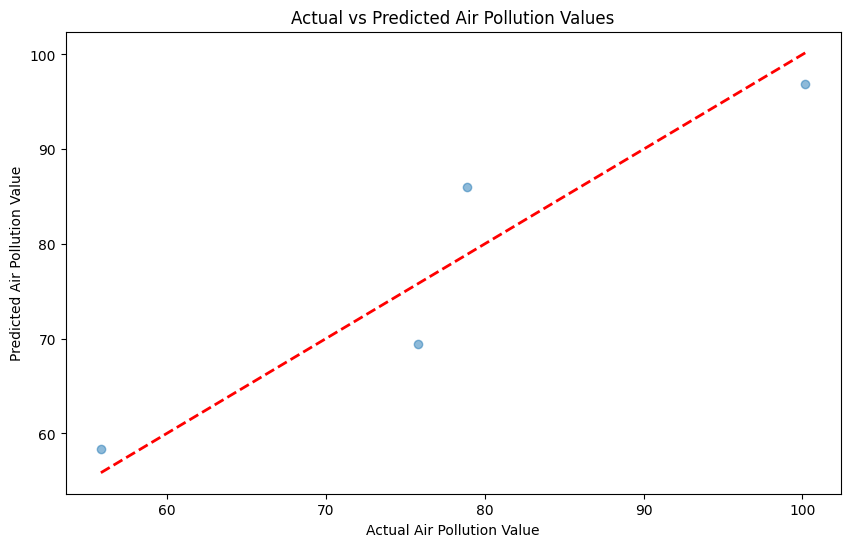

/var/folders/m_/q9gtbt5110q8qm3xhl5j_j9m0000gn/T/ipykernel_75447/1903181556.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hk_pollutant_data['predicted_value'] = model.predict(X)


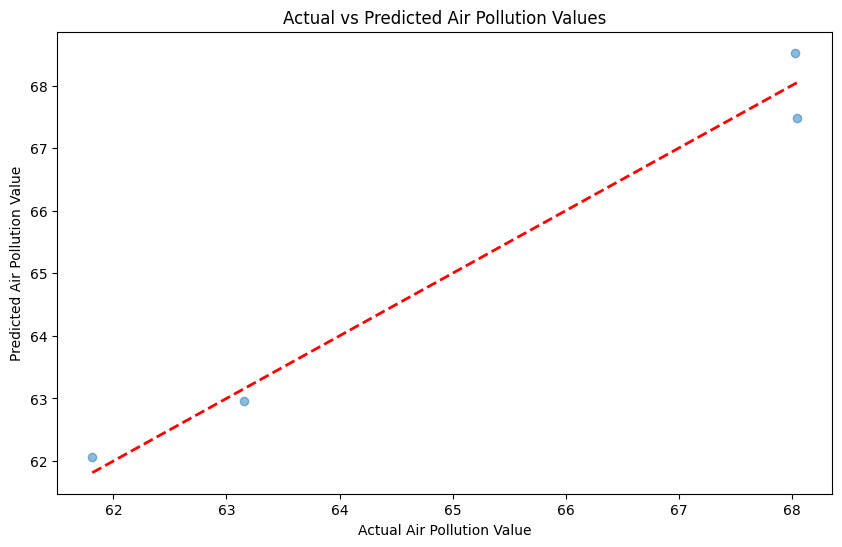

/var/folders/m_/q9gtbt5110q8qm3xhl5j_j9m0000gn/T/ipykernel_75447/1903181556.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hk_pollutant_data['predicted_value'] = model.predict(X)


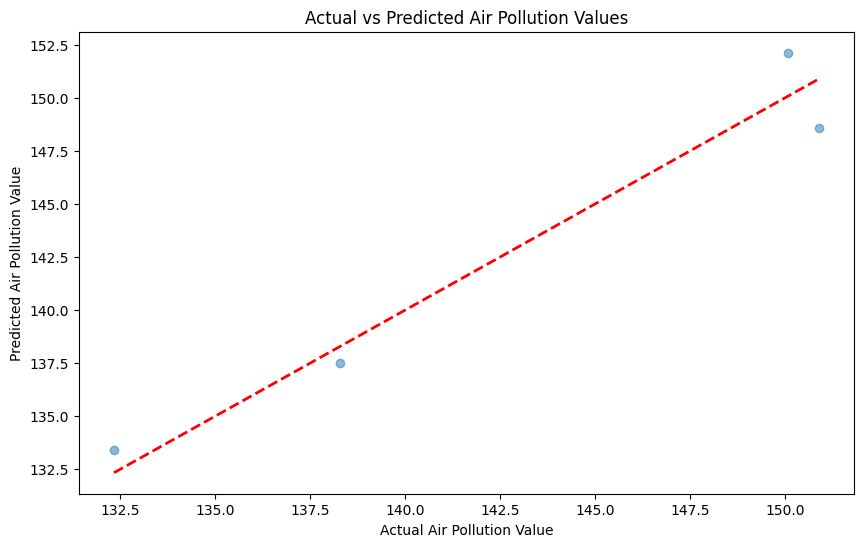

/var/folders/m_/q9gtbt5110q8qm3xhl5j_j9m0000gn/T/ipykernel_75447/1903181556.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hk_pollutant_data['predicted_value'] = model.predict(X)


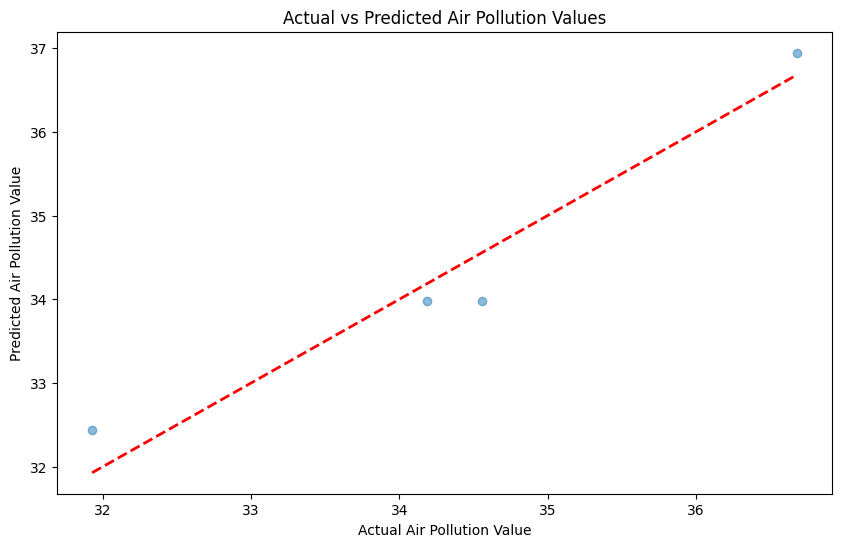

/var/folders/m_/q9gtbt5110q8qm3xhl5j_j9m0000gn/T/ipykernel_75447/1903181556.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hk_pollutant_data['predicted_value'] = model.predict(X)


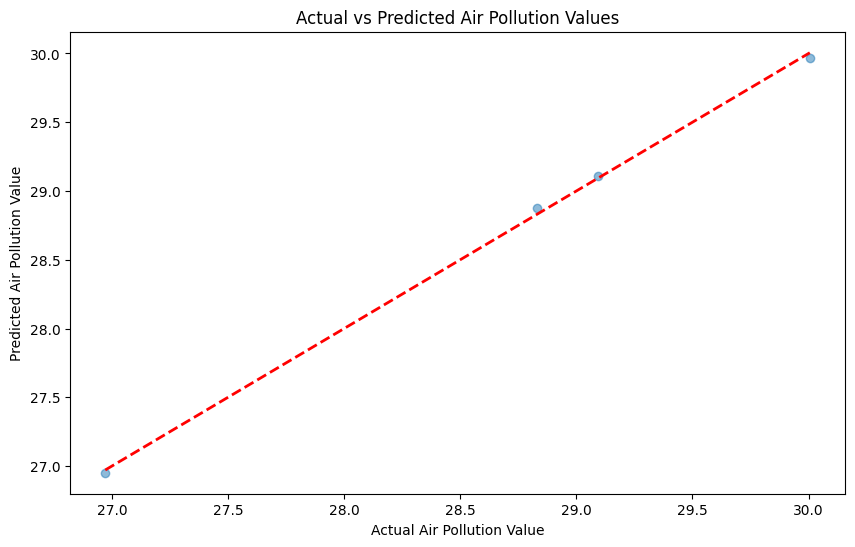

In [135]:
for pollutant in hk_pollutants:
    hk_pollutant_data = hk_merged_data[hk_merged_data['pollutant'] == pollutant]
    # 准备数据
    X = hk_pollutant_data[['hk_total_vehicles', 'large_vehicle_ratio']]
    X = sm.add_constant(X)  # 加入常数项
    y = hk_pollutant_data['value']
    
    # 建立线性回归模型
    model = sm.OLS(y, X).fit()
    
    # 生成预测值
    hk_pollutant_data['predicted_value'] = model.predict(X)
    
    # 绘制实际值与预测值对比
    plt.figure(figsize=(10, 6))
    plt.scatter(hk_pollutant_data['value'], hk_pollutant_data['predicted_value'], alpha=0.5)
    plt.plot([hk_pollutant_data['value'].min(), hk_pollutant_data['value'].max()], [hk_pollutant_data['value'].min(), hk_pollutant_data['value'].max()], 'r--', lw=2)
    plt.title('Actual vs Predicted Air Pollution Values')
    plt.xlabel('Actual Air Pollution Value')
    plt.ylabel('Predicted Air Pollution Value')
    plt.show()